In [1]:
import networkx as nx
from networkx.algorithms.community import kernighan_lin_bisection
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Qubit


In [2]:
def circuit_to_graph(circuit):
    graph = nx.Graph()
    qubit_indices = {qubit: idx for idx, qubit in enumerate(circuit.qubits)}
    
    for gate in circuit.data:
        if len(gate[1]) == 2:  # two-qubit gates
            q1, q2 = gate[1]
            idx1, idx2 = qubit_indices[q1], qubit_indices[q2]
            if graph.has_edge(idx1, idx2):
                graph[idx1][idx2]['weight'] += 1
            else:
                graph.add_edge(idx1, idx2, weight=1)
        # Handle single-qubit and three-qubit gates as necessary

    return graph

In [25]:
def partition_graph(graph, k):
    partitions = [graph]
    while len(partitions) < k:
        new_partitions = []
        for part in partitions:
            nodes1, nodes2 = kernighan_lin_bisection(part)
            subgraph1 = graph.subgraph(nodes1).copy()
            subgraph2 = graph.subgraph(nodes2).copy()
            new_partitions.extend([subgraph1, subgraph2])
        partitions = new_partitions
    return partitions

In [166]:
# Determine nodes requiring teleportation
def find_teleportation_nodes(graph, partitions):
    partition_nodes = {node: i for i, partition in enumerate(partitions) for node in partition}
    teleportation_nodes = set()
    
    for u, v in graph.edges:
        if partition_nodes[u] != partition_nodes[v]:
            teleportation_nodes.add(u)
            teleportation_nodes.add(v)
    
    return teleportation_nodes

In [154]:
def partition_to_circuit(partitions, original_circuit):
    circuits = [QuantumCircuit(len(part.nodes)) for part in partitions]
    qubit_map = {qubit: idx for idx, qubit in enumerate(original_circuit.qubits)}
    return circuits, qubit_map
    # for gate in original_circuit.data:
    #     if len(gate[1]) == 2:  # two-qubit gates
    #         q1, q2 = gate[1]
    #         idx1, idx2 = qubit_map[q1], qubit_map[q2]
    #         for i, part in enumerate(partitions): 
    #             if idx1 in part.nodes and idx2 in part.nodes:
    #                 circuits[i].append(gate)
    #                 break
    #         else:
    #             # Handle inter-partition gates (teleportation)
    #             pass
    #     elif len(gate[1]) == 1:  # single-qubit gates
    #         q = gate[1][0]
    #         idx = qubit_map[q]
    #         for i, part in enumerate(partitions):
    #             if idx in part.nodes:
    #                 circuits[i].append(gate)
    #                 break

    # return circuits

In [26]:

def evaluate_partition(graph, partitions):
    conductance = nx.algorithms.cuts.conductance(graph, partitions[0].nodes)
    modularity = nx.algorithms.community.modularity(graph, [part.nodes for part in partitions])
    # Telecommunication cost (example, needs more detailed implementation)
    tele_cost = sum(graph.edges[edge]['weight'] for edge in graph.edges if edge[0] in partitions[0] and edge[1] in partitions[1])
    return conductance, modularity, tele_cost

In [35]:
qc = QuantumCircuit(6)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.h(2)
qc.cx(2, 3)
qc.x(3)
qc.cx(3, 4)
qc.y(4)
qc.cx(4, 5)
qc.z(5)
qc.cx(5, 0)
qc.ccx(0, 1, 2)
qc.barrier()
qc.h(1)
qc.cx(1, 3)
qc.cx(3, 5)
qc.rx(1.57, 0)
qc.ry(1.57, 2)
qc.rz(1.57, 4)

qc.draw()

┌───┐                                             ┌───┐      ░ »
q_0: ┤ H ├──■──────────────────────────────────────────┤ X ├──■───░─»
     └───┘┌─┴─┐                                        └─┬─┘  │   ░ »
q_1: ─────┤ X ├──■───────────────────────────────────────┼────■───░─»
          └───┘┌─┴─┐┌───┐                                │  ┌─┴─┐ ░ »
q_2: ──────────┤ X ├┤ H ├──■─────────────────────────────┼──┤ X ├─░─»
               └───┘└───┘┌─┴─┐┌───┐                      │  └───┘ ░ »
q_3: ────────────────────┤ X ├┤ X ├──■───────────────────┼────────░─»
                         └───┘└───┘┌─┴─┐┌───┐            │        ░ »
q_4: ──────────────────────────────┤ X ├┤ Y ├──■─────────┼────────░─»
                                   └───┘└───┘┌─┴─┐┌───┐  │        ░ »
q_5: ────────────────────────────────────────┤ X ├┤ Z ├──■────────░─»
                                             └───┘└───┘           ░ »
«     ┌──────────┐          
«q_0: ┤ Rx(1.57) ├──────────
«     └──┬───┬───┘          
«q_1: ───┤ H ├──────■───────
«     ┌──┴───┴───┐  │       
«q_2: ┤ Ry(1.57) ├──┼───────
«     └──────────┘┌─┴─┐     
«q_3: ────────────┤ X ├──■──
«     ┌──────────┐└───┘  │  
«q_4: ┤ Rz(1.57) ├───────┼──
«     └──────────┘     ┌─┴─┐
«q_5: ─────────────────┤ X ├
«                      └───┘

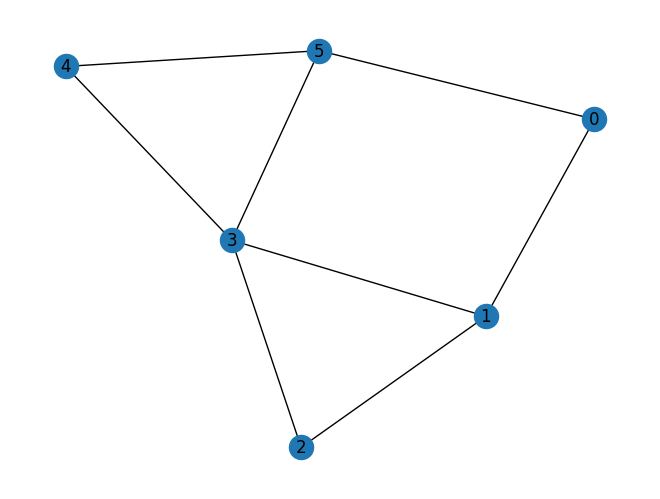

In [36]:
graph = circuit_to_graph(qc)
# Plot the graph
nx.draw(graph, with_labels=True)

In [39]:
# Partition the graph
k = 2  # Number of desired partitions
partitions = partition_graph(graph, k)

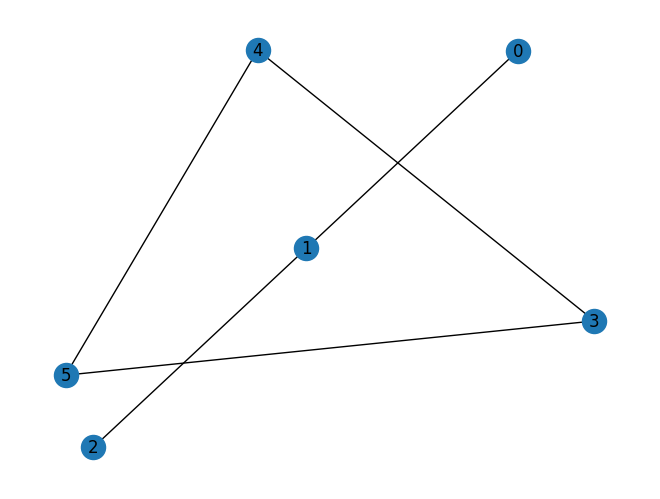

In [171]:
# Draw for part in partitions
for part in partitions:
    nx.draw(part, with_labels=True)

In [169]:
teleportation_nodes = find_teleportation_nodes(graph, [part.nodes for part in partitions])
teleportation_nodes

{0, 1, 2, 3, 5}

In [156]:
# Convert partitions back to quantum circuits (for visualization)
circuits, qubit_map = partition_to_circuit(partitions, qc)
qubit_map

{Qubit(QuantumRegister(6, 'q'), 0): 0,
 Qubit(QuantumRegister(6, 'q'), 1): 1,
 Qubit(QuantumRegister(6, 'q'), 2): 2,
 Qubit(QuantumRegister(6, 'q'), 3): 3,
 Qubit(QuantumRegister(6, 'q'), 4): 4,
 Qubit(QuantumRegister(6, 'q'), 5): 5}

In [ ]:

# Evaluate the partitions
conductance, modularity, tele_cost = evaluate_partition(graph, partitions)

print(f"Conductance: {conductance}")
print(f"Modularity: {modularity}")
print(f"Telecommunication Cost: {tele_cost}")

In [2]:
import networkx as nx
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap

# Define the architecture
architecture = nx.Graph()
# QPU1 connections (fully connected)
architecture.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])
# QPU2 connections (fully connected)
architecture.add_edges_from([(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)])
# Inter-QPU connection
architecture.add_edge(2, 6)


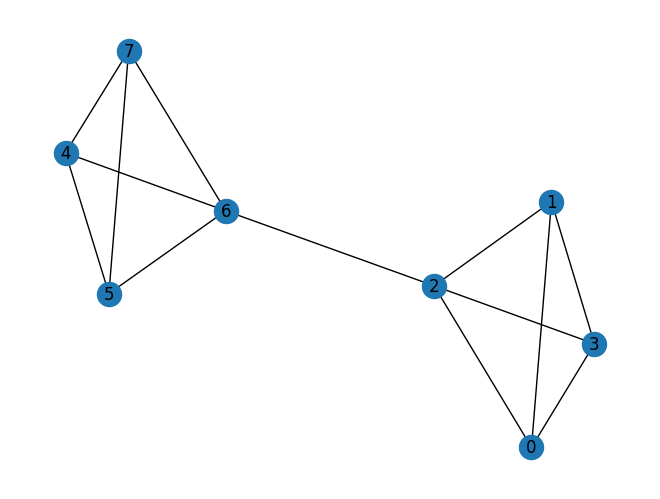

In [3]:
# Draw achitecture
nx.draw(architecture, with_labels=True)

In [4]:
# Create a complex quantum circuit
qc = QuantumCircuit(8)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.h(2)
qc.cx(2, 3)
qc.cx(3, 4)
qc.cx(4, 5)
qc.cx(5, 6)
qc.cx(6, 7)
qc.ccx(0, 1, 2)
qc.barrier()
qc.h(1)
qc.cx(1, 3)
qc.cx(3, 5)
qc.rx(1.57, 0)
qc.ry(1.57, 2)
qc.rz(1.57, 4)

# Function to add teleportation between qubits q1 and q2
def add_teleportation(circuit, q1, q2):
    circuit.h(q1)
    circuit.cx(q1, q1 + 1)
    circuit.cx(q2, q1 + 1)
    circuit.h(q2)
    circuit.measure(q2, 0)
    circuit.measure(q1 + 1, 1)
    circuit.cx(q1, q2)
    circuit.cz(q1, q2)

qc.draw()

┌───┐                                         ░ ┌──────────┐          
q_0: ┤ H ├──■───────────────────■──────────────────░─┤ Rx(1.57) ├──────────
     └───┘┌─┴─┐                 │                  ░ └──┬───┬───┘          
q_1: ─────┤ X ├──■──────────────■──────────────────░────┤ H ├──────■───────
          └───┘┌─┴─┐┌───┐     ┌─┴─┐                ░ ┌──┴───┴───┐  │       
q_2: ──────────┤ X ├┤ H ├──■──┤ X ├────────────────░─┤ Ry(1.57) ├──┼───────
               └───┘└───┘┌─┴─┐└───┘                ░ └──────────┘┌─┴─┐     
q_3: ────────────────────┤ X ├──■──────────────────░─────────────┤ X ├──■──
                         └───┘┌─┴─┐                ░ ┌──────────┐└───┘  │  
q_4: ─────────────────────────┤ X ├──■─────────────░─┤ Rz(1.57) ├───────┼──
                              └───┘┌─┴─┐           ░ └──────────┘     ┌─┴─┐
q_5: ──────────────────────────────┤ X ├──■────────░──────────────────┤ X ├
                                   └───┘┌─┴─┐      ░                  └───┘
q_6: ───────────────────────────────────┤ X ├──■───░───────────────────────
                                        └───┘┌─┴─┐ ░                       
q_7: ────────────────────────────────────────┤ X ├─░───────────────────────
                                             └───┘ ░

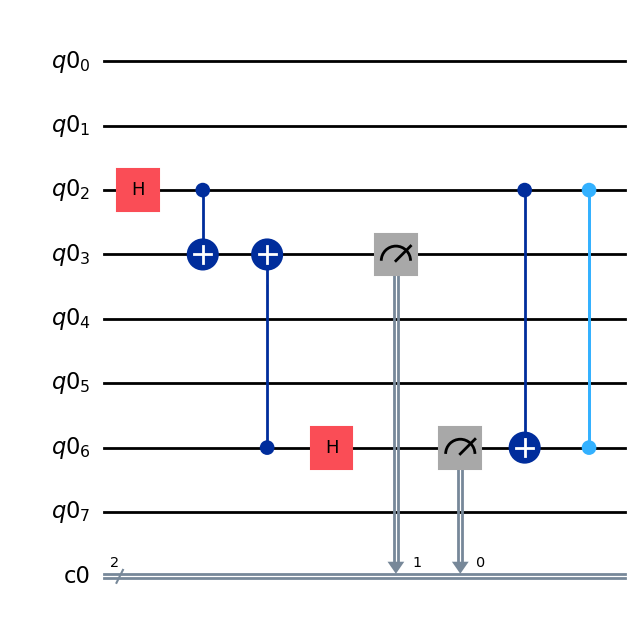

In [5]:
# Example usage in a quantum circuit
qr = QuantumRegister(8)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr,cr)  # 8 qubits and 2 classical bits for measurement
add_teleportation(qc, 2, 6)
qc.draw('mpl')


In [32]:
qc2 = QuantumCircuit(8)
add_teleportation(qc2, 2, 6)

CircuitError: 'Index 0 out of range for size 0.'

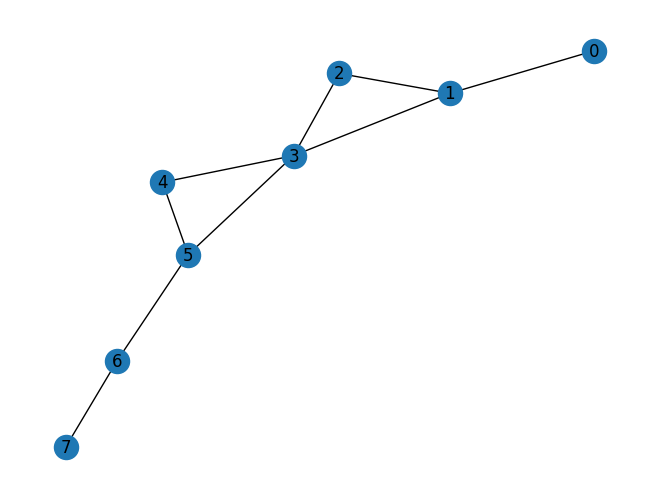

In [5]:
# Convert the circuit to a graph
def circuit_to_graph(circuit):
    graph = nx.Graph()
    qubit_indices = {qubit: idx for idx, qubit in enumerate(circuit.qubits)}
    
    for gate in circuit.data:
        if len(gate[1]) == 2:  # two-qubit gates
            q1, q2 = gate[1]
            idx1, idx2 = qubit_indices[q1], qubit_indices[q2]
            if graph.has_edge(idx1, idx2):
                graph[idx1][idx2]['weight'] += 1
            else:
                graph.add_edge(idx1, idx2, weight=1)
        elif len(gate[1]) == 1:  # single-qubit gates
            q = gate[1][0]
            idx = qubit_indices[q]
            if not graph.has_node(idx):
                graph.add_node(idx)
    
    return graph

graph = circuit_to_graph(qc)

# Draw the graph
nx.draw(graph, with_labels=True)

[4, 5, 6, 7]
[0, 1, 2, 3]


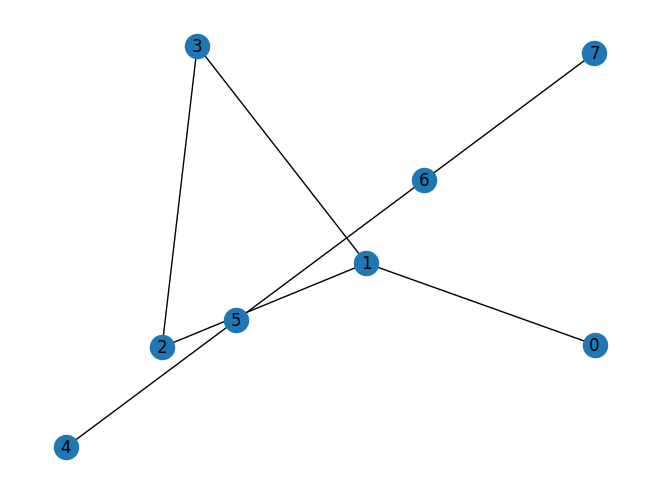

In [6]:
def partition_graph(graph, k):
    partitions = [graph]
    while len(partitions) < k:
        new_partitions = []
        for part in partitions:
            nodes1, nodes2 = kernighan_lin_bisection(part)
            subgraph1 = graph.subgraph(nodes1).copy()
            subgraph2 = graph.subgraph(nodes2).copy()
            new_partitions.extend([subgraph1, subgraph2])
        partitions = new_partitions
    return partitions

partitions = partition_graph(graph, 2)

# Draw the partitions
for part in partitions:
    nx.draw(part, with_labels=True)
    print(part.nodes)

In [30]:
# Partition the circuit (qubits 0-3 in QPU1, qubits 4-7 in QPU2)
partition1 = partitions[0].nodes
partition2 = partitions[1].nodes

# Create new circuits for each partition
partitioned_qc1 = QuantumCircuit(4, 2)  # 4 qubits in QPU1, 2 classical bits for teleportation
partitioned_qc2 = QuantumCircuit(4, 2)  # 4 qubits in QPU2, 2 classical bits for teleportation

def map_gate_to_partition(circuits, partition1, partition2, partitioned_qc1, partitioned_qc2):
    for gate in circuits.data:
        if len(gate[1]) == 2:  # two-qubit gates
            q1, q2 = gate[1]
            if (circuits.find_bit(q1)[0] in partition1 and circuits.find_bit(q2)[0] in partition2) or (circuits.find_bit(q1)[0] in partition2 and circuits.find_bit(q2)[0]in partition1):
                # Inter-QPU gate, add teleportation
                add_teleportation(partitioned_qc1, 2, 6)  # qubit 2 in QPU1 to qubit 6 in QPU2
            elif circuits.find_bit(q1)[0] in partition1:
                partitioned_qc1.append(gate[0], [partitioned_qc1.qubits[circuits.find_bit(q1)[0]], partitioned_qc1.qubits[circuits.find_bit(q2)[0]]])
            else:
                partitioned_qc2.append(gate[0], [partitioned_qc2.qubits[circuits.find_bit(q1)[0] - 4], partitioned_qc2.qubits[circuits.find_bit(q2)[0] - 4]])
        elif len(gate[1]) == 1:  # single-qubit gates
            q = gate[1][0]
            if circuits.find_bit(q)[0] in partition1:
                partitioned_qc1.append(gate[0], [partitioned_qc1.qubits[circuits.find_bit(q)[0]]])
            else:
                partitioned_qc2.append(gate[0], [partitioned_qc2.qubits[circuits.find_bit(q)[0] - 4]])

# Map gates to partitions
map_gate_to_partition(qc, partition1, partition2, partitioned_qc1, partitioned_qc2)

CircuitError: 'Index 6 out of range for size 4.'

In [27]:

# Create a new circuit for each partition
def partition_to_circuit(partitions, original_circuit):
    circuits = [QuantumCircuit(len(part)) for part in partitions]
    qubit_map = {qubit: idx for idx, qubit in enumerate(original_circuit.qubits)}
    
    for gate in original_circuit.data:
        if len(gate[1]) == 2:  # two-qubit gates
            q1, q2 = gate[1]
            idx1, idx2 = qubit_map[q1], qubit_map[q2]
            for i, part in enumerate(partitions):
                new_qubits = (Qubit(circuits[i].qregs[0], 0), Qubit(circuits[i].qregs[0], 1))
                new_gate = gate.replace(qubits=new_qubits)
                if idx1 in part and idx2 in part:
                    circuits[i].append(new_gate)
                    break
        elif len(gate[1]) == 1:  # single-qubit gates
            q = gate[1][0]
            idx = qubit_map[q]
            for i, part in enumerate(partitions):
                if idx in part:
                    circuits[i].append(gate.replace(qubits=circuits[i].qregs))
                    break

    return circuits

partitioned_circuits = partition_to_circuit(partitions, qc)

# Draw the partitioned circuits
for circ in partitioned_circuits:
    print(circ)
    circ.draw()

     ┌───┐             ┌───┐                ┌───┐     ┌──────────┐┌──────────┐
q_0: ┤ H ├──■────■─────┤ H ├─────────■──────┤ H ├──■──┤ Rx(1.57) ├┤ Ry(1.57) ├
     ├───┤┌─┴─┐┌─┴─┐   ├───┤       ┌─┴─┐    ├───┤┌─┴─┐├──────────┤├──────────┤
q_1: ┤ H ├┤ X ├┤ X ├───┤ H ├───────┤ X ├────┤ H ├┤ X ├┤ Rx(1.57) ├┤ Ry(1.57) ├
     ├───┤├───┤├───┤┌──┴───┴───┐┌──┴───┴───┐└───┘└───┘└──────────┘└──────────┘
q_2: ┤ H ├┤ H ├┤ H ├┤ Rx(1.57) ├┤ Ry(1.57) ├──────────────────────────────────
     ├───┤├───┤├───┤├──────────┤├──────────┤                                  
q_3: ┤ H ├┤ H ├┤ H ├┤ Rx(1.57) ├┤ Ry(1.57) ├──────────────────────────────────
     └───┘└───┘└───┘└──────────┘└──────────┘                                  
                           ┌──────────┐
q_0: ─────■────────■────■──┤ Rz(1.57) ├
        ┌─┴─┐    ┌─┴─┐┌─┴─┐├──────────┤
q_1: ───┤ X ├────┤ X ├┤ X ├┤ Rz(1.57) ├
     ┌──┴───┴───┐└───┘└───┘└──────────┘
q_2: ┤ Rz(1.57) ├──────────────────────
     ├──────────┤                      
q_3: ┤ Rz

In [31]:

# Define the coupling maps for the QPUs
coupling_map_qpu1 = CouplingMap([(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)])
coupling_map_qpu2 = CouplingMap([(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)])

# Transpile the circuits for each QPU
transpiled_circuits = []
for i, partitioned_circuit in enumerate(partitioned_circuits):
    if i == 0:
        transpiled_circuits.append(transpile(partitioned_circuit, coupling_map=coupling_map_qpu1))
    else:
        transpiled_circuits.append(transpile(partitioned_circuit, coupling_map=coupling_map_qpu2))

# Draw the transpiled circuits
for i, circuit in enumerate(transpiled_circuits):
    print(f"Transpiled circuit for QPU {i+1}:")
    display(circuit.draw())


Transpiled circuit for QPU 1:


global phase: 6.2824
                                 ┌───┐     ┌─────────────────────────────┐
q_0 -> 0 ───────────■────────────┤ H ├──■──┤ U3(1.5708,-1.57,0.00079633) ├
                  ┌─┴─┐          ├───┤┌─┴─┐├─────────────────────────────┤
q_1 -> 1 ─────────┤ X ├──────────┤ H ├┤ X ├┤ U3(1.5708,-1.57,0.00079633) ├
         ┌────────┴───┴─────────┐└───┘└───┘└─────────────────────────────┘
q_2 -> 2 ┤ U3(3.1408,0,-1.5716) ├─────────────────────────────────────────
         ├──────────────────────┤                                         
q_3 -> 3 ┤ U3(3.1408,0,-1.5716) ├─────────────────────────────────────────
         └──────────────────────┘

Transpiled circuit for QPU 2:


┌──────────┐            
      q_2 -> 0 ┤ Rz(1.57) ├────────────
               ├──────────┤            
      q_3 -> 1 ┤ Rz(1.57) ├────────────
               └──────────┘            
ancilla_0 -> 2 ────────────────────────
                                       
ancilla_1 -> 3 ────────────────────────
                           ┌──────────┐
      q_0 -> 4 ─────■──────┤ Rz(1.57) ├
                  ┌─┴─┐    ├──────────┤
      q_1 -> 5 ───┤ X ├────┤ Rz(1.57) ├
                  └───┘    └──────────┘
ancilla_2 -> 6 ────────────────────────
                                       
ancilla_3 -> 7 ────────────────────────